In [1]:
import numpy as np
import umap
import torch
import json
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.decomposition import PCA

In [2]:
def get_layer_activations(internal_reps, layer_idx):
    """
    Get the activations of a specific layer for all problems and all examples.

    internal_reps: list[tuple[tensor]] where internal_reps[question_num][layer_num]
     is a tensor of shape [batch=1, num_tokens, d_model=4096]

    We will return a tensor of shape [num_questions, num_tokens, d_model=4096]
    for the given layer
    """
    return torch.cat([internal_reps[i][layer_idx] for i in range(len(internal_reps))])


In [3]:
# Define the directory containing the results
results_dir = 'xyUMAP20240709'

In [5]:
# Load the answers and problems files
answers = np.load(os.path.join(results_dir, 'answers.npy'))
problems = np.load(os.path.join(results_dir, 'problems.npy'))

# Load the internal representations and logits
internal_reps = torch.load(os.path.join(results_dir, 'internal_reps.pt'), map_location=torch.device('cpu'))
logits = torch.load(os.path.join(results_dir, 'logits.pt'))

# Load the arguments
with open(os.path.join(results_dir, 'args.json'), 'r') as f:
    args = json.load(f)

# Display the shapes and types of the loaded data
print("Answers shape:", answers.shape)
print("Problems shape:", problems.shape)
print("Internal Reps type:", type(internal_reps))
print("Internal Reps length:", len(internal_reps))
print("Logits type:", type(logits))
print("Logits length:", len(logits))

# Let's inspect the internal representations and logits a bit more closely
print("Example internal representation shape:", internal_reps[0][0][0].shape)
print("Example logits shape:", logits[0].shape)

# Display some examples from the loaded data
print("\nExample answers:", answers[0])
print("\nExample problems:", problems[0])
print("\nExample internal representation:", internal_reps[0][0][0])
print("\nExample logits:", logits[0])

Answers shape: (100, 1)
Problems shape: (100, 17)
Internal Reps type: <class 'list'>
Internal Reps length: 100
Logits type: <class 'torch.Tensor'>
Logits length: 100
Example internal representation shape: torch.Size([17, 4096])
Example logits shape: torch.Size([17, 128256])

Example answers: [868]

Example problems: [128000     87    284    220    975     11    379    284    220     16
     26   9093    865    489    379    284    220]

Example internal representation: tensor([[-8.2970e-05,  2.5749e-04, -2.4605e-04,  ..., -3.2425e-04,
         -2.1553e-04,  4.7112e-04],
        [-2.0752e-03, -1.4038e-03,  6.1035e-03,  ...,  2.2888e-03,
          6.1951e-03,  1.1414e-02],
        [ 1.0376e-03, -6.8054e-03,  6.2943e-04,  ...,  2.5482e-03,
         -8.3618e-03, -8.8501e-03],
        ...,
        [ 3.3569e-03, -3.3760e-04,  2.4719e-03,  ..., -8.3008e-03,
          3.2654e-03, -7.3242e-03],
        [ 1.0376e-03, -6.8054e-03,  6.2943e-04,  ...,  2.5482e-03,
         -8.3618e-03, -8.8501e-03]

In [7]:
# compute the actual token-wise answers
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(args['model_name'])

# find the argmax over the logits for each 
# problem to get the predicted class

# logits has shape [num_questions, num_tokens, vocab_size]

final_logits = logits[:, -1, :]

# take the argmax over the final dim
predicted_class = torch.argmax(final_logits, dim=1)

# decode each prediction individually
predicted_class_str = [tokenizer.decode(i) for i in predicted_class]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
str_answers = [tokenizer.decode(i) for i in answers[:, 0]]

str_problems = []
for i in range(problems.shape[0]):
    str_problems.append(tokenizer.decode(problems[i, :]).replace('\n', ' '))

num_correct = 0
for i in range(len(str_answers)):
    if str_answers[i] == predicted_class_str[i]:
        num_correct += 1

num_correct / len(str_answers)

1.0

In [9]:
# make a set of integer-valued answers
int_answers = [int(a) for a in str_answers]

In [79]:
import numpy as np
from sklearn.cross_decomposition import CCA
import numpy as np



def CCA_Proj(layer_activations, N=2):
    flattened_reps = layer_activations.reshape(layer_activations.shape[0], -1).cpu().numpy()

    int_answers_array = np.array(int_answers)

    # normalize
    int_answers_normed = (int_answers_array - int_answers_array.mean()) / int_answers_array.std()
    flattened_reps_normed = (flattened_reps - flattened_reps.mean(axis=0)) / (flattened_reps.std(axis=0) + 1e-6)

    print(int_answers_normed.shape, flattened_reps_normed.shape)
    # Perform CCA
    cca = CCA(n_components=1)
    cca.fit(flattened_reps_normed, int_answers_normed)
    U = cca.transform(flattened_reps)
    print(U.shape)
    # get covarience between U and int_answers
    cov = np.corrcoef(U.squeeze(), int_answers_normed.squeeze())
    print(cov)
    return


    # Get the canonical correlation coefficients
    cca_coefficients = cca.coef_
    # Get the absolute correlation coefficients
    abs_corr_coeffs = np.abs(cca_coefficients)
    print(sorted(abs_corr_coeffs), len(abs_corr_coeffs))
    # Sort the correlation coefficients in descending order
    sorted_indices = np.argsort(abs_corr_coeffs)[::-1]

    # Get the top N highest correlation coefficients
    top_n_indices = sorted_indices[:N]

    # Get the projection of the top N highest correlation coefficients
    U = cca.transform(flattened_reps)
    print(U.shape)
    top_n_projection = U[:, top_n_indices]
layer_activations = get_layer_activations(internal_reps, 31)

CCA_Proj(layer_activations)

(100,) (100, 69632)
(100, 1)
[[ 1.        -0.9950301]
 [-0.9950301  1.       ]]


In [13]:
from sklearn.cross_decomposition import PLSRegression
def PLS_Proj(layer_activations, int_answers_array, N=2):
    flattened_reps = layer_activations.reshape(layer_activations.shape[0], -1).cpu().numpy()
    int_answers_array = np.array(int_answers)

    # Normalize the data
    int_answers_normed = (int_answers_array - int_answers_array.mean()) / int_answers_array.std()
    flattened_reps_normed = (flattened_reps - flattened_reps.mean(axis=0)) / (flattened_reps.std(axis=0) + 1e-6)

    # Create and fit the PLS regression model
    pls = PLSRegression(n_components=N)
    pls.fit(flattened_reps_normed, int_answers_normed)

    # Project the data onto the PLS components
    U = pls.transform(flattened_reps)
    return U


0.6296539747373148
0.634071535737504
0.6411748726809342
0.46177498243108317
0.648073981807526
0.465417318666089
0.6868647801816171
0.5427673329942357
0.6602839246252088
0.5879158107569944
0.629295692235483
0.577538760304388
0.5635395689989217
0.59977786784203
0.5373626631844792
0.608659195322811
0.5085123307141344
0.6123819689481137
0.5054395770239654
0.6123722800373786
0.49038442548660804
0.5913389669970348
0.4883800673292915
0.5648457087657276
0.4962349901628215
0.5494352539964777
0.5105711163019084
0.5369523372530177
0.534617679803628
0.5238147198804207
0.548896547272879
0.5323386904368338
0.5785242115028892
0.5489840292247107
0.6146526076112885
0.5720322260893983
0.6336362251650185
0.578377175224495
0.6987856367552414
0.6700781591884531
0.7237458034845616
0.6973664760892848
0.7912504199076376
0.7491735854111536
0.8382978201911198
0.791761507960268
0.8323426583577062
0.7903020443504992
0.8353305276284752
0.795493903053713
0.8416975829765952
0.8090136733638835
0.8336014317580267
0.80

Text(0.5, 1.0, 'Correlation Coefficient between PLS Component and Answer')

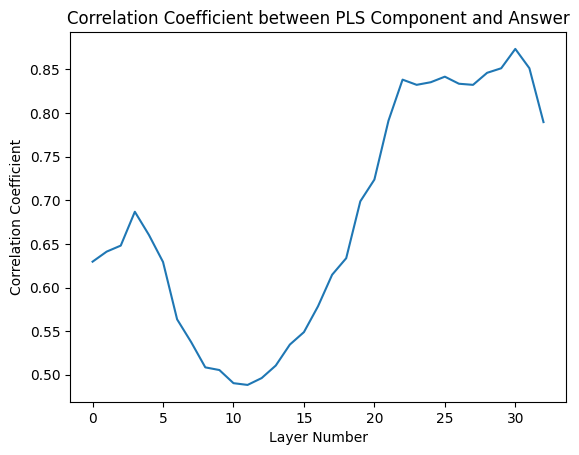

In [19]:
corrs = []
for layer_num in range(num_layers):
    int_answers_normed = (int_answers_array - int_answers_array.mean()) / int_answers_array.std()

    layer_activations = get_layer_activations(internal_reps, layer_num)
    U = PLS_Proj(layer_activations, int_answers)

    corrs.append(np.abs(np.corrcoef(U[:, 0], int_answers_normed)[0,1]))

import matplotlib.pyplot as plt
plt.plot(corrs)
plt.xlabel('Layer Number')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation Coefficient between PLS Component and Answer')

In [14]:
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

int_answers_array = np.array(int_answers)
# for dim_reduction_func in (get_pca, get_umap, get_class_relevance_pca, get_class_pca_and_umap):
for dim_reduction_func in (PLS_Proj,):
    # iterate through each layer
    num_layers = 33
    purity_by_layer = []
    for layer_num in range(num_layers):
        layer_activations = get_layer_activations(internal_reps, layer_num)
        low_dim_embedding = dim_reduction_func(layer_activations, int_answers_array)
        
        # Create Plotly figure
        fig = make_subplots(rows=1, cols=1)
        
        # Add scatter plot
        scatter = go.Scatter(
            x=low_dim_embedding[:, 0],
            y=low_dim_embedding[:, 1],
            mode='markers',
            marker=dict(
                size=8,
                color=int_answers,
                colorscale='Viridis',
                showscale=True
            ),
            text=[f"Problem: {prob}<br>Answer: {ans}<br>Predicted: {pred}" 
                for prob, ans, pred in zip(str_problems, str_answers, predicted_class_str)],
            hoverinfo='text'
        )
        
        fig.add_trace(scatter)
        
        # Update layout
        fig.update_layout(
            title=f'{dim_reduction_func.__name__} for Layer {layer_num}',
            xaxis_title='Dim 1',
            yaxis_title='Dim 2',
            width=1000,
            height=800
        )
        
        # Save as interactive HTML
        pio.write_html(fig, file=f'{results_dir}/{dim_reduction_func.__name__}_layer_{layer_num}.html')
        
        # Save as static PNG
        pio.write_image(fig, file=f'{results_dir}/{dim_reduction_func.__name__}_layer_{layer_num}.png')
        
        # Clear the figure to free up memory
        fig.data = []
        fig.layout = {}

0.6296539747373148
0.634071535737504
0.6411748726809342
0.46177498243108317
0.648073981807526
0.465417318666089
0.6868647801816171
0.5427673329942357
0.6602839246252088
0.5879158107569944
0.629295692235483
0.577538760304388
0.5635395689989217
0.59977786784203
0.5373626631844792
0.608659195322811
0.5085123307141344
0.6123819689481137
0.5054395770239654
0.6123722800373786
0.49038442548660804
0.5913389669970348
0.4883800673292915
0.5648457087657276
0.4962349901628215
0.5494352539964777
0.5105711163019084
0.5369523372530177
0.534617679803628
0.5238147198804207
0.548896547272879
0.5323386904368338
0.5785242115028892
0.5489840292247107
0.6146526076112885
0.5720322260893983
0.6336362251650185
0.578377175224495
0.6987856367552414
0.6700781591884531
0.7237458034845616
0.6973664760892848
0.7912504199076376
0.7491735854111536
0.8382978201911198
0.791761507960268
0.8323426583577062
0.7903020443504992
0.8353305276284752
0.795493903053713
0.8416975829765952
0.8090136733638835
0.8336014317580267
0.80